## Sample workflow for training DL model

Notebook Author: Maria J. Molina, National Center for Atmospheric Research, Boulder, CO

In [1]:
# load basic python libraries for visualization and testing along the way

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

### Generate list of IDs for training

Select the respective options (e.g., train only with MCSs in masks, certain months, etc).

In [10]:
import id_selector

ids_object = id_selector.IDSelector(main_path=id_selector.main_path_003, 
                                    start_year=id_selector.start_year, end_year=id_selector.end_year, 
                                    month_only=[3,4,5,6], year_only=None, mcs_only=True, 
                                    percent_train=0.7,
                                    ens_num='003')

IDs_array = ids_object.generate_IDarray()
train_IDs, test_IDs = ids_object.generate_traintest_split(IDs_array, seed=0)
print(f"total number of training data based on selections : {train_IDs.shape[0]}")

starting ID generation...
ID generation complete.
total number of training data based on selections : 2036


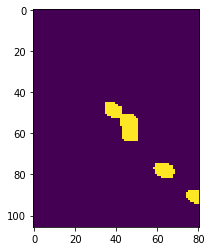

In [3]:
# quick visualization of random train ID mask (sanity check)
ds = xr.open_dataset(f'{id_selector.main_path_003}/dl_files/mask_ID{train_IDs[10]}.nc')
ds['binary_tag'].sum()
plt.imshow(ds['binary_tag'])

### Initiate Keras DataGenerator class object with select variables and pre-generated data IDs

In [4]:
import dataloader

# list of variables for training and corresponding CESM file type
variables = ["QBOT","PSL"]
variable_hnum = ["h3","h4"]

training_generator = dataloader.DataGenerator(list_IDs = train_IDs, 
                                              path_dataID = f"{dataloader.main_path_003}/dl_files/", 
                                              variable = variables, 
                                              ens_num = "003",
                                              h_num = variable_hnum, 
                                              height = None, 
                                              batch_size = 32, dim = (106, 81), 
                                              n_channels=len(variables), 
                                              n_classes=2, shuffle=True)

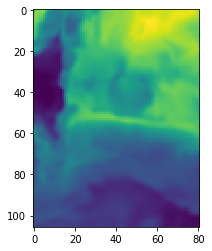

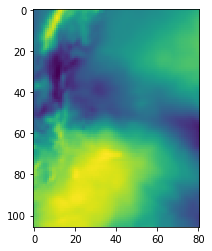

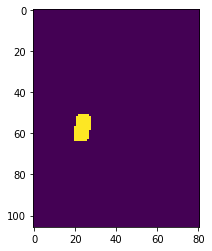

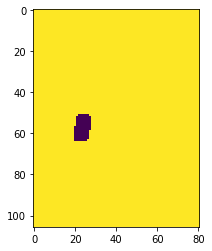

In [5]:
# quick test of keras dataloader for sanity check
a, b = training_generator.__getitem__(0)
plt.imshow(a[0,:,:,0]);plt.show()
plt.imshow(a[0,:,:,1]);plt.show()
plt.imshow(b[0,:,:,0]);plt.show()
plt.imshow(b[0,:,:,1]);plt.show()

### Create model using the Keras functional API, which is more flexible than the tf.keras.Sequential API

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

Choose activation function.

In [7]:
activation_func = 'relu'

Similar model architecture as DL-front paper.

Model: "dlfront_style"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 106, 81, 2)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 106, 81, 80)       4080      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 106, 81, 80)       160080    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 106, 81, 80)       160080    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 106, 81, 2)        4002      
Total params: 328,242
Trainable params: 328,242
Non-trainable params: 0
_________________________________________________________________


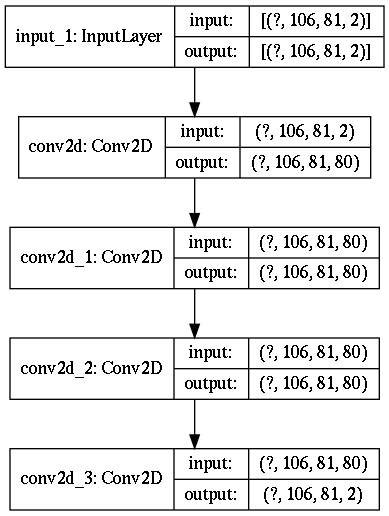

In [8]:
inputs = keras.Input(shape=(106, 81, len(variables,)))

conv2d = layers.Conv2D(80, 
                       (5,5),
                       strides=(1,1),
                       padding='same', 
                       data_format='channels_last',
                       dilation_rate=1, activation=activation_func, 
                       use_bias=True, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='zeros', 
                       #kernel_regularizer=l2(0.001), bias_regularizer=None, 
                       activity_regularizer=None, 
                       kernel_constraint=None, 
                       bias_constraint=None)

x = conv2d(inputs)

x = layers.Conv2D(80, 
                       (5,5),
                       strides=(1,1),
                       padding='same', 
                       data_format='channels_last',
                       dilation_rate=1, activation=activation_func, 
                       use_bias=True, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='zeros', 
                       #kernel_regularizer=l2(0.001), bias_regularizer=None, 
                       activity_regularizer=None, 
                       kernel_constraint=None, 
                       bias_constraint=None)(x)

x = layers.Conv2D(80, 
                       (5,5),
                       strides=(1,1),
                       padding='same', 
                       data_format='channels_last',
                       dilation_rate=1, activation=activation_func, 
                       use_bias=True, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='zeros', 
                       #kernel_regularizer=l2(0.001), bias_regularizer=None, 
                       activity_regularizer=None, 
                       kernel_constraint=None, 
                       bias_constraint=None)(x)

outputs = layers.Conv2D(2, 
                       (5,5),
                       strides=(1,1),
                       padding='same', 
                       data_format='channels_last',
                       dilation_rate=1, activation='softmax', 
                       use_bias=True, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='zeros', 
                       #kernel_regularizer=l2(0.001), bias_regularizer=None, 
                       activity_regularizer=None, 
                       kernel_constraint=None, 
                       bias_constraint=None)(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="dlfront_style")

model.summary()

keras.utils.plot_model(model, show_shapes=True)

In [10]:

# model architecture looks good, now compile

model.compile(optimizer=keras.optimizers.Adam(lr=0.0001), loss='categorical_crossentropy', 
              metrics=['accuracy', 'mean_squared_error', 'mean_absolute_error'])


In [11]:

#train just for one epoch for testing

model.fit_generator(generator=training_generator,
                    ## use_multiprocessing=True,
                    workers=0
                   )


63/63 [==============================] - 386s 6s/step - loss: 0.4778 - accuracy: 0.9703 - mean_squared_error: 0.0297 - mean_absolute_error: 0.0297
